# 3.1 Baseline Model

In [1]:
#!pip install nibabel
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [3]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [4]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [5]:
image_array.shape

(391, 61, 73, 61)

In [6]:
# load GAN data
gan_data_m = np.load('/project/ds6050-soa2wg/team_lambda_II/gan_pos_female_ep500_cs3000_si50.npy')
gan_data_f = np.load('/project/ds6050-soa2wg/team_lambda_II/gan_pos_male_ep500_cs3000_si50.npy')

In [7]:
gan_data_m.shape

(50, 61, 73, 61)

In [8]:
gan_data_f.shape

(50, 61, 73, 61)

In [9]:
gan_data_cases = np.concatenate((gan_data_f, gan_data_m))

In [10]:
gan_data_cases.shape

(100, 61, 73, 61)

In [11]:
image_array = np.vstack((image_array,gan_data_cases)) 

In [12]:
image_array.shape

(491, 61, 73, 61)

In [13]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array)
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [14]:
# gan_pheno
gan_pheno_cases = np.ones((gan_data_cases.shape[0],), dtype=int)
#gan_pheno_control = np.zeros((123,), dtype=int)

# merge cases + control pheno
#gan_pheno = np.concatenate((gan_pheno_cases,gan_pheno_control))
# append to pheno_array
all_pheno = np.concatenate((pheno_array, gan_pheno_cases))

In [15]:
all_pheno

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, all_pheno, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

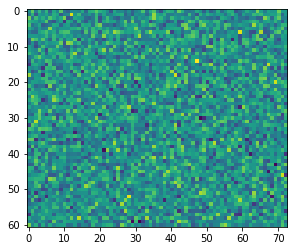

In [21]:
plt.imshow(x_train[0][30].T)

In [22]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 32
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-03 15:26:25.970202: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-03 15:26:25.970252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-aw34-20c1): /proc/driver/nvidia/version does not exist
2022-05-03 15:26:25.973408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Architecture 

Define a 3D convolutional neural network
To make the model easier to understand, we structure it into blocks. The architecture of the 3D CNN used in this example is based on this paper.

In [23]:
def get_model(width=61, height=73, depth=61):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Normalization(axis=None)(inputs) #ADDED NORMALIZATION LAYER

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=16, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=61, height=73, depth=61)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 normalization (Normalizatio  (None, 61, 73, 61, 1)    3         
 n)                                                              
                                                                 
 conv3d (Conv3D)             (None, 61, 73, 61, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 36, 30, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 36, 30, 64)   256       
 ormalization)                                                   
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['acc',tf.keras.metrics.AUC()],
)

# # Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "3d_image_classification_Cxa.h5", save_best_only=True
# )
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# # Train the model, doing validation at the end of each epoch
# epochs = 50
# model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     shuffle=True,
#     verbose=2,
#     callbacks=[checkpoint_cb, early_stopping_cb],
# )

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping_cb],
)

Epoch 1/50
10/10 - 651s - loss: 0.5654 - acc: 0.7051 - auc: 0.7444 - val_loss: 0.6005 - val_acc: 0.7429 - val_auc: 0.7886 - 651s/epoch - 65s/step
Epoch 2/50
10/10 - 662s - loss: 0.4798 - acc: 0.7692 - auc: 0.8087 - val_loss: 0.5882 - val_acc: 0.7238 - val_auc: 0.8302 - 662s/epoch - 66s/step
Epoch 3/50
10/10 - 619s - loss: 0.4465 - acc: 0.7821 - auc: 0.8453 - val_loss: 0.5175 - val_acc: 0.7429 - val_auc: 0.8306 - 619s/epoch - 62s/step
Epoch 4/50
10/10 - 612s - loss: 0.4154 - acc: 0.8205 - auc: 0.8837 - val_loss: 0.8084 - val_acc: 0.6476 - val_auc: 0.8353 - 612s/epoch - 61s/step
Epoch 5/50
10/10 - 657s - loss: 0.4117 - acc: 0.8141 - auc: 0.8789 - val_loss: 0.8686 - val_acc: 0.6476 - val_auc: 0.8423 - 657s/epoch - 66s/step
Epoch 6/50
10/10 - 754s - loss: 0.4100 - acc: 0.8013 - auc: 0.8862 - val_loss: 0.9355 - val_acc: 0.6476 - val_auc: 0.8346 - 754s/epoch - 75s/step
Epoch 7/50
10/10 - 806s - loss: 0.3993 - acc: 0.8205 - auc: 0.8986 - val_loss: 0.7000 - val_acc: 0.6476 - val_auc: 0.8496 - 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["auc_4", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# Load best weights.
model.load_weights("3d_image_classification_Cxa.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_test[0])

In [ ]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)